In [1]:
from IPython.core.display import HTML
display(HTML('<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:'
             + 'empty {padding: 0; border: 0;}</style>'));

In [2]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm
from glob import glob
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
sys.path.append('./model_opts')
from feature_extraction import *
from model_options import *
from image_ops import *

In [5]:
torch.cuda.set_device(3)

In [6]:
model_options = get_model_options(train_type='imagenet')
image_transforms = get_image_transforms()['imagenet']

In [7]:
root = 'vessel_assets/'
assets = glob(root + '*.jpg')
dictlist = []
for asset in assets:
    imgstr = asset.split('/')[1]
    row = {'ImageName': imgstr}
    dictlist.append(row)
image_df = pd.DataFrame(dictlist)
print(image_df)

        ImageName
0     aip_030.jpg
1     aep_057.jpg
2     aep_055.jpg
3     aip_072.jpg
4    eqlsc047.jpg
..            ...
557  eqlsc093.jpg
558   aip_095.jpg
559  eqlsc033.jpg
560   art_050.jpg
561  eqlsc126.jpg

[562 rows x 1 columns]


In [8]:
class StimulusSet(Dataset):
    def __init__(self, csv, root_dir, image_transforms=None):
        
        self.root = os.path.expanduser(root_dir)
        self.transforms = image_transforms
        
        if isinstance(csv, pd.DataFrame):
            self.df = csv
        if isinstance(csv, str):
            self.df = pd.read_csv(csv)
        
        self.images = self.df.ImageName

    def __getitem__(self, index):
        filename = os.path.join(self.root, self.images.iloc[index])
        img = Image.open(filename).convert('RGB')
        
        if self.transforms:
            img = self.transforms(img)
            
        return img
    
    def __len__(self):
        return len(self.images)

In [9]:
stimulus_loader = DataLoader(dataset=StimulusSet(image_df, root, image_transforms), batch_size=64)

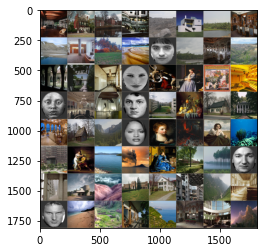

In [10]:
get_dataloader_sample(stimulus_loader)

In [11]:
class Array2StimulusSet(Dataset):
    def __init__(self, img_array, image_transforms=None):
        self.transforms = image_transforms
        if isinstance(img_array, np.ndarray):
            self.images = img_array
        if isinstance(img_array, str):
            self.images = np.load(img_array)

    def __getitem__(self, index):
        img = Image.fromarray(self.images[index]).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
        return img
    
    def __len__(self):
        return self.images.shape[0]

In [12]:
random_loader = DataLoader(dataset=Array2StimulusSet('random_noise.npy', image_transforms), batch_size=64)

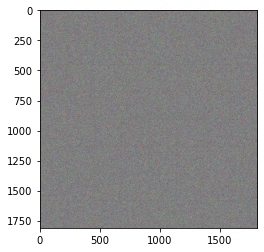

In [13]:
get_dataloader_sample(random_loader)

In [14]:
imagenet_images = np.load('imagenet_sample.npy')

In [15]:
imagenet_loader = DataLoader(dataset=Array2StimulusSet(imagenet_images[:1000], image_transforms), batch_size=64)

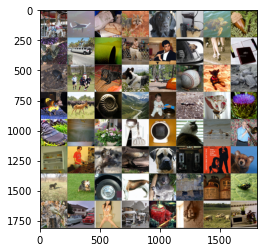

In [16]:
get_dataloader_sample(imagenet_loader)

In [17]:
model_string = 'alexnet_imagenet'
model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']

model = eval(model_call)
model = model.eval()
model = model.cuda()

In [18]:
stimulus_features = get_all_feature_maps(model, stimulus_loader, numpy=False)

In [19]:
random_features = get_all_feature_maps(model, random_loader, numpy=False)

In [33]:
imagenet_features = get_all_feature_maps(model, imagenet_loader, numpy=False)

In [35]:
get_feature_map_size(imagenet_features)

4302.751999999999

In [36]:
cosine = nn.CosineSimilarity(dim=0, eps=1e-6)
euclid = nn.PairwiseDistance(eps=1e-6)

In [37]:
activity_dictlist = []
for map_key in tqdm(list(stimulus_features.keys())[-2:]):
    target_map = stimulus_features[map_key]
    random_map = random_features[map_key]
    imagenet_map = imagenet_features[map_key]
    random_mean = random_map.mean(axis=1)
    imagenet_mean = imagenet_map.mean(axis=1)
    for target_i, target_activity in enumerate(tqdm(target_map, leave=False)):
        random_cosines = torch.zeros(random_map.shape[0])
        random_euclids = torch.zeros(random_map.shape[0])
        for random_i, random_activity in enumerate(random_map):
            random_cosines[random_i] = cosine(target_activity, random_activity)
            random_euclids[random_i] = torch.dist(target_activity, random_activity)
            
        imagenet_cosines = torch.zeros(random_map.shape[0])
        imagenet_euclids = torch.zeros(random_map.shape[0])
        for imagenet_i, imagenet_activity in enumerate(imagenet_map):
            imagenet_cosines[imagenet_i] = cosine(target_activity, imagenet_activity)
            imagenet_euclids[imagenet_i] = torch.dist(target_activity, imagenet_activity)
    
        image_name = image_df.ImageName.iloc[target_i]
        image_type = image_name.translate(str.maketrans('', '', '0123456789')).replace('.jpg', '')
        
        activity_dictlist.append({
            'image': image_name, 'image_type': image_type, 'model': model_name, 
            'model_layer': map_key, 'model_layer_index': map_key.split('-')[1],
            'mean_activity': target_activity.abs().mean().item(),
            'total_activity': target_activity.abs().sum().item(),
            
            'mean_cosine_to_noise': random_cosines.abs().mean().item(),
            'mean_distance_to_noise': random_euclids.abs().mean().item(),
            'mean_cosine_to_imagenet': imagenet_cosines.abs().mean().item(),
            'mean_distance_to_imagenet': imagenet_euclids.abs().mean().item(),
        })
        
activity_df = pd.DataFrame(activity_dictlist)

In [42]:
activity_df

,image,image_type,model,model_layer,model_layer_index,mean_activity,total_activity,mean_cosine_to_noise,mean_distance_to_noise,mean_cosine_to_imagenet,mean_distance_to_imagenet
0,aip_030.jpg,aip_,alexnet,ReLU-7,7,0.242552,993.493958,0.011456,75.194229,0.074707,94.126129
1,aep_057.jpg,aep_,alexnet,ReLU-7,7,0.251813,1031.426147,0.044791,73.848907,0.081262,93.743279
2,aep_055.jpg,aep_,alexnet,ReLU-7,7,0.273273,1119.327026,0.031349,79.322121,0.075343,97.772469
3,aip_072.jpg,aip_,alexnet,ReLU-7,7,0.262976,1077.148438,0.029088,79.923164,0.066701,98.594284
4,eqlsc047.jpg,eqlsc,alexnet,ReLU-7,7,0.147458,603.986328,0.105850,63.547997,0.061160,88.691170
...,...,...,...,...,...,...,...,...,...,...,...
1119,eqlsc093.jpg,eqlsc,alexnet,Linear-3,3,2.915806,2915.805908,0.099834,118.772606,0.192660,154.473007
1120,aip_095.jpg,aip_,alexnet,Linear-3,3,2.448365,2448.364990,0.022314,111.475555,0.311791,136.993851
1121,eqlsc033.jpg,eqlsc,alexnet,Linear-3,3,2.186760,2186.760010,0.034376,100.556816,0.232409,142.509552
1122,art_050.jpg,art_,alexnet,Linear-3,3,2.351538,2351.538330,0.372231,88.326340,0.257852,131.176483


In [38]:
activity_df.groupby('image_type')['mean_cosine_to_imagenet'].mean()

image_type
F.a.     0.152315
F.a.n    0.154166
F.b.     0.157026
M.a.     0.148183
M.b.     0.153331
aep_     0.150487
aip_     0.172103
art_     0.150913
eqlsc    0.133659
Name: mean_cosine_to_imagenet, dtype: float64

In [ ]:
arr1 = np.random.randn(3)
arr2 = np.random.randn(3)
arr3 = np.random.randn(3)
moving_average = np.mean(np.array((np.mean(arr1), np.mean(arr2), np.mean(arr3))))
combined_average = np.mean(np.stack((arr1,arr2,arr3)))
print('moving average:', moving_average)
print('combined average:', combined_average)